# 4APR23 In Class Exercise

This notebook demonstrates (1) how to run coalescent simulations through pedigrees and (2) how to find IBD segments from an msprime simulation

In [83]:
# load modules
import msprime
import io
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG, display
import matplotlib.pyplot as plt
import tskit
import numpy as np
import itertools as it

A pedigree file is used to describe pedigree structures. Perhaps surprisingly, it is very intuitive. Each row corresponds to an individual and there are columns denoting their mother and father. Let's load a subset of the Quebec pedigrees, taken from here: https://github.com/LukeAndersonTrocme/genome_simulations

In [20]:
# load file
pedigree = pd.read_csv("~/ascending_sample_pedigree.txt", dtype=str)

# absent mothers/fathers are denoted by 0 in the file; replace this 0 with "."
pedigree["mother"] = pedigree["mother"].apply(lambda x: "." if x == "0" else x)
pedigree["father"] = pedigree["father"].apply(lambda x: "." if x == "0" else x)

# in the simulations, we want to take our samples from the 0th generation, so set the is_sample column to 1 if the sample is in the 0th gen
pedigree["is_sample"] = pedigree["generation"].apply(lambda x: "1" if x == "0" else "0")

# we need a population label FC = French Canadian
pedigree["population"] = "FC"

print(pedigree)

          ind  mother  father generation is_sample population
0      409153  295170  295169          0         1         FC
1      443151  442562  442561          0         1         FC
2      408477  861890  861889          0         1         FC
3      408790  863184  863183          0         1         FC
4      409098  716486  716485          0         1         FC
...       ...     ...     ...        ...       ...        ...
41518   76422       .       .         17         0         FC
41519   18525       .       .         17         0         FC
41520   18527       .       .         17         0         FC
41521   18539       .       .         17         0         FC
41522   65396       .       .         17         0         FC

[41523 rows x 6 columns]


There are 41,523 individuals in this pedigree. This is a _huge_ number of individuals, but only a small subset of the individuals in the larger Balsac pedigree. We can also see that the pedigree contains individuals that lived up to 17 generations ago in the early 17th century. Let's take a look at the number of individuals by generation.

In [21]:
for generation in range(18):
    gen_df = pedigree[pedigree.generation == str(generation)]
    print("Generation " + str(generation) + ": " + str(gen_df.shape[0]))

Generation 0: 140
Generation 1: 280
Generation 2: 556
Generation 3: 1017
Generation 4: 1772
Generation 5: 2772
Generation 6: 3913
Generation 7: 4987
Generation 8: 5490
Generation 9: 5340
Generation 10: 4412
Generation 11: 3528
Generation 12: 2945
Generation 13: 2437
Generation 14: 1433
Generation 15: 413
Generation 16: 78
Generation 17: 10


### Exercise
What patterns do you see? Based solely on the number of individuals in each generation, what inference might you make about the demographic history of Quebec? Hint: this pedigree was made by taking 140 present-day individuals and adding all of their known ancestors.

Let's see if there are any relatives in the current generation. To do this we have two steps (1) for each individual in generation 0, retrieve their ancestors in each generation 1 through 17 and (2) for each pair of individuals in generation, see which ancestors overlap (and in which generation, and how many of them).

In [140]:
indv_ancestors = {}

# iterate through all individuals in gen 0
for _, i in pedigree[pedigree.generation == "0"].iterrows():
    # get the id
    indv = i["ind"]
    ancestors = {indv}
    indv_ancestors[indv] = {}
    
    # iterate up the pedigree until there are no more ancestors
    while len(ancestors) > 0:
        
        # subset the current gen of ancestors
        subset = pedigree[pedigree.ind.isin(ancestors)]
        
        # iterate through the current gen's ancestors and add to dict
        for _, ancestor in subset.iterrows():
            indv_ancestors[indv][ancestor["ind"]] = ancestor["generation"]
          
        # get next set of ancestors
        ancestors = set(subset["mother"])
        ancestors |= set(subset["father"])
        ancestors -= {"."}

relationships = []

for id1, id2 in it.combinations(indv_ancestors, r = 2):
    set1 = set(indv_ancestors[id1])
    set2 = set(indv_ancestors[id2])
    
    if len(set1 & set2) > 0:
        gen1 = [int(indv_ancestors[id1][i]) for i in set1 & set2]
        gen2 = [int(indv_ancestors[id2][i]) for i in set1 & set2]
        min1, min2 = min(gen1), min(gen2)
        if min1 < 5 and min2 < 5:
            relationships.append([id1, id2, min1, gen1.count(min1)])

relatives = pd.DataFrame(relationships, columns = ["id1", "id2", "gen_mrca", "n_ancestors"])

relatives.drop_duplicates(["gen_mrca", "n_ancestors"])

,id1,id2,gen_mrca,n_ancestors
0,409153,408769,4,2
5,409111,409084,3,2
13,217891,868572,4,1
24,408911,409124,4,4
44,408917,408950,3,1


In [58]:
# convert the pedigree structure to str
txt = """\
# id parent0 parent1 time is_sample population
"""

txt += "\n".join(pedigree.apply(lambda x: " ".join(x), axis = 1).values.tolist())

Now we are ready to run our pedigree coalescent simulation through msprime. This simulation will be run in two steps: (1) simulate through the pedigree until all lineages have reached a founder in the pedigree and (2) with the remaining lineages, simulate either a standard Hudson coalescent or a WF coalescent. In step 2, we must supply a demographic model; a good choice would be a standard European demographic model, but here we will use a simple model of 10,000 individuals in a constant-sized population. After specifying the demography, we will use the `parse_pedigree` function to reach in the pedigree structure.

In [60]:
# to start, we must specificy a demographic history for the French Canadian population once the lineages reach founders in the population
demography = msprime.Demography()

# each we're just going to make it a constant sized population of 10,0000
demography.add_population(name="FC", initial_size=10000)

ped = msprime.parse_pedigree(io.StringIO(txt), sequence_length=1000000, demography=demography)

First let's take a look at the individuals in the pedigree. These are the individuals in the pedigree. Notice that their IDs have been converted to an integer, but their original ID is preserved in the metadata.

In [62]:
display(ped.individuals)

id,flags,location,parents,metadata
0,0,,"140, 280",{'file_id': '409153'}
1,0,,"141, 281",{'file_id': '443151'}
2,0,,"142, 282",{'file_id': '408477'}
3,0,,"143, 283",{'file_id': '408790'}
4,0,,"144, 284",{'file_id': '409098'}
5,0,,"145, 285",{'file_id': '409266'}
6,0,,"146, 286",{'file_id': '409032'}
7,0,,"147, 287",{'file_id': '409434'}
8,0,,"148, 288",{'file_id': '408769'}
9,0,,"149, 289",{'file_id': '409282'}


Now let's look at the nodes of the pedigree. First, note that there are twice as many nodes as individuals; this is because each individual has two parents (two separate lineages). If you look at the first two rows, you'll notice that the 0 node and the 1 node correspond to the same individaul (individual 0).

In [63]:
display(ped.nodes)

id,flags,population,individual,time,metadata
0,1,0,0,0,
1,1,0,0,0,
2,1,0,1,0,
3,1,0,1,0,
4,1,0,2,0,
5,1,0,2,0,
6,1,0,3,0,
7,1,0,3,0,
8,1,0,4,0,
9,1,0,4,0,


Now let's run the first part of the simulation. We need to specify the intial state of the simulation, which is the pedigree. Here we're setting an arbitrarily high recombination rate that is constant across our simulated genome, which is 1MB long. Looking at the outputted tree-sequence, there are 25,271 trees. Also note that there are 280 samples. This is because there are 140 individuals in generation 0 and because they are diploid, there are 280 samples.


In [64]:
ped_ts = msprime.sim_ancestry(
    initial_state=ped, model="fixed_pedigree",
    recombination_rate=0.00001, random_seed = 19)

ped_ts

Next let's take a look at the first tree. We see that the tree spans the first 81 basepairs of the simulated genome and that there are 250 roots of the tree.

In [68]:
tree = ped_ts.first()

tree

### Exercise

How many coalescent events occurred in the pedigree?

There are still 250 lineages and we need to finish the simulation. To do this, we run the simulation again, but specificying the initial state as the pedigree coalescent. We will use the arbitrary demography we defined earlier and use the Wright Fisher model (dtwf = discrete-time Wright Fisher)

In [70]:
full_ts = msprime.sim_ancestry(
    initial_state=ped_ts, demography=demography, model="dtwf", random_seed = 19)

full_ts

Let's take a look at the first tree. Now there is only one root, so all of our lineages have coalesced!

In [72]:
full_ts.first()

We have identified several relatives. We expect them to share IBD. Let's take a look at a pair of these individuals and look at when, at different places along the genome, their MRCA lived.

In [144]:
relatives.sort_values("gen_mrca")

,id1,id2,gen_mrca,n_ancestors
46,416144,416147,3,2
44,408917,408950,3,1
5,409111,409084,3,2
39,416955,417018,3,2
8,409422,409437,3,2
18,408691,408950,3,2
37,416163,416162,3,2
11,409084,408828,3,2
33,416118,416124,3,2
27,409095,409082,4,4


In the next cell, we will plot on the x-axis the index of the tree (there are ~27k trees) and on the y-axis (which is log-scaled), the MRCA of the pair chosen pair of individuals. Note that we also have to choose which lineage we want to plot; since each individual has 2 lineages, there are 4 possible pairs of lineages we can choose.

Below, I am choosing a pair of individuals 416144 and 416147. They are 2nd cousins (they share a pair of great-grandparents), 416144 through his mother and 416147 through his father.

TMRCA: 3.0 generations


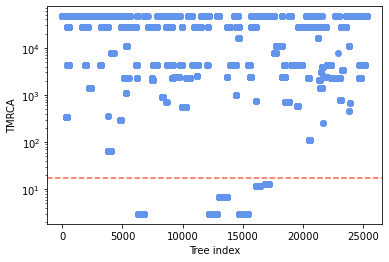

In [163]:
# lin corresponds to the which lineage to use (either 1 or 2)
def plot_mrca(id1, id2, lin1, lin2):
    index1 = pedigree[pedigree.ind == id1].index[0] * 2
    index2 = pedigree[pedigree.ind == id2].index[0] * 2
    
    sample1 = index1 + (lin1 - 1)
    sample2 = index2 + (lin2 - 1)
        
    mrca = [tree.tmrca(sample1, sample2) for tree in full_ts.trees()]
    print("TMRCA: " + str(min(mrca)) + " generations")
    
    plt.scatter(x = np.arange(len(mrca)), y = mrca, color = "cornflowerblue")
    plt.yscale("log")
    
    plt.axhline(y=17, color='tomato', linestyle='--')
    
    plt.xlabel("Tree index")
    plt.ylabel("TMRCA")
    plt.show()
    
    
plot_mrca("416144", "416147", 2, 1)

Let's look at the sample pair of individuals (416144 and 416147), but look at their paternal and maternal lineage, respectively. You'll notice that they _also_ share a recent common ancestor through their other set of parents.

TMRCA: 7.0 generations


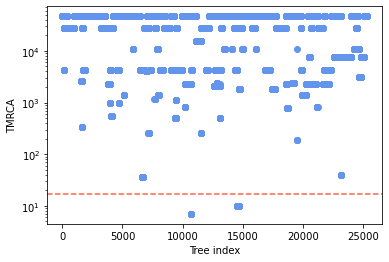

In [164]:
plot_mrca("416144", "416147", 1, 2)

`msprime` has a built-in function for computing IBD. Let's do that for the same pair. The `within` allows us to specify which lineages to analyze. The `max_time` argument allows us to set a time threshold for how far in the past we want to look for IBD. The `min_span` arguments tells the function to only output segments of that length (in base pairs). I'm also keeping track of the amount of IBD that the pair shares from their second cousin relationship. Second cousins should share 6.25% of their haploid genome IBD with each other, which would be ~62.5 kbp of a million bp genome. Here, we see that they share 74 kbp IBD with each other, which is in agreement with the expectation.

In [167]:
tot = 0
for seg in full_ts.ibd_segments(within = [271, 272], store_pairs=True, store_segments=True, max_time = 17, min_span = 1000)[(271, 272)]:
    print(seg)
    if seg.node == 3974:
        tot += (seg.right - seg.left)
        
tot

IdentitySegment(left=247082.0, right=267652.0, node=3974)
IdentitySegment(left=480710.0, right=506674.0, node=3974)
IdentitySegment(left=579732.0, right=607435.0, node=3974)
IdentitySegment(left=512846.0, right=539761.0, node=30025)
IdentitySegment(left=635011.0, right=648979.0, node=73872)
IdentitySegment(left=670440.0, right=675877.0, node=79167)
IdentitySegment(left=664686.0, right=670440.0, node=79167)


74237.0